In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder

# シグモイド関数の定義
def sigmoid(x):
    return 1./(1+np.exp(-x))

# シミュレーション用のクラス
class Simulator():
    def set_num_data(self, num_data):
        self.num_data = num_data

    def generate_linear_data(self):
        num_data = self.num_data
        # 説明変数x1, x2を生成し、介入と報酬を決定
        self.df = pd.DataFrame({
            "x1": np.random.normal(size=num_data),
            "x2": np.random.normal(size=num_data),
        }).assign(
            # 介入確率をシグモイド関数で決定し、3つの介入（0, 1, 2）をランダムに割り当て
            prob_t0 = lambda df: sigmoid(df.x1 + df.x2),
            prob_t1 = lambda df: sigmoid(df.x1 - df.x2),
            prob_t2 = lambda df: 1 - df.prob_t0 - df.prob_t1,
            t = lambda df: np.random.choice([0, 1, 2], size=num_data, p=[0.3, 0.4, 0.3]),
            # 各介入に応じた報酬を設定
            reward = lambda df: df.x1 - df.x2 + df.t * 0.5
        )
        return self.df

    def generate_nonlinear_data(self):
        num_data = self.num_data
        self.df = pd.DataFrame({
            "x1": np.random.normal(size=num_data),
            "x2": np.random.normal(size=num_data),
        }).assign(
            prob_t0 = lambda df: sigmoid(np.sin(df.x1) - df.x2**2),
            prob_t1 = lambda df: sigmoid(df.x1**2 - df.x2),
            prob_t2 = lambda df: 1 - df.prob_t0 - df.prob_t1,
            t = lambda df: np.random.choice([0, 1, 2], size=num_data, p=[0.3, 0.4, 0.3]),
            reward = lambda df: sigmoid(np.sin(df.x1) - df.x2**4) + df.t * 0.5
        )
        return self.df

    def IPS(self):
        df = self.df

        # One-hot encoding for treatment variable t
        encoder = OneHotEncoder(sparse=False)
        t_encoded = encoder.fit_transform(df[['t']])

        # 介入の確率をロジスティック回帰で推定
        model = LogisticRegression(multi_class='multinomial', max_iter=200).fit(df[["x1", "x2"]], df["t"])
        t_pred = model.predict_proba(df[["x1", "x2"]])

        # 逆確率重み付き平均
        df["reward_treatment"] = np.sum(df["reward"] * t_encoded / t_pred, axis=1)

        # 全ての介入に対する推定された因果効果の誤差を計算
        true_effect = df["t"] * 0.5
        return abs((df["reward_treatment"] - df["reward"]).mean() - true_effect.mean())

    def DM(self):
        df = self.df

        # One-hot encoding for treatment variable t
        encoder = OneHotEncoder(sparse=False)
        t_encoded = encoder.fit_transform(df[['t']])

        # 線形回帰で報酬を予測（説明変数はx1, x2, t）
        model = LinearRegression().fit(np.hstack([df[["x1", "x2"]], t_encoded]), df["reward"])

        # 介入ごとの報酬を予測
        df["reward_treatment"] = np.sum([model.predict(np.hstack([df[["x1", "x2"]], t_encoded[:, [i]]])) for i in range(3)], axis=0)

        # 全ての介入に対する推定された因果効果の誤差を計算
        true_effect = df["t"] * 0.5
        return abs((df["reward_treatment"] - df["reward"]).mean() - true_effect.mean())

    def sim_linear(self):
        ress = []
        for num_data in [100, 200, 400, 800, 1600, 6400, 12800]:
            res = {"num_data": num_data}
            self.set_num_data(num_data)
            ips = []
            dm = []
            for _ in range(100):
                self.generate_linear_data()
                ips.append(self.IPS())
                dm.append(self.DM())
            res["IPS"] = np.mean(ips)
            res["DM"] = np.mean(dm)
            ress.append(res)
        return pd.DataFrame(ress).set_index("num_data")

    def sim_nonlinear(self):
        ress = []
        for num_data in [100, 200, 400, 800, 1600, 12800]:
            res = {"num_data": num_data}
            self.set_num_data(num_data)
            ips = []
            dm = []
            for _ in range(100):
                self.generate_nonlinear_data()
                ips.append(self.IPS())
                dm.append(self.DM())
            res["IPS"] = np.mean(ips)
            res["DM"] = np.mean(dm)
            ress.append(res)
        return pd.DataFrame(ress).set_index("num_data")


In [2]:
simulator = Simulator()

# 線形モデルを線形モデルでFitingする場合
- DMの精度はIPSよりもよい

In [3]:
simulator.sim_linear().plot(ylabel="error")

ValueError: operands could not be broadcast together with shapes (100,) (100,3) 

# 非線形モデルを線形モデルでFitingする場合
- IPSの精度がDMを上回る

<Axes: xlabel='num_data', ylabel='error'>

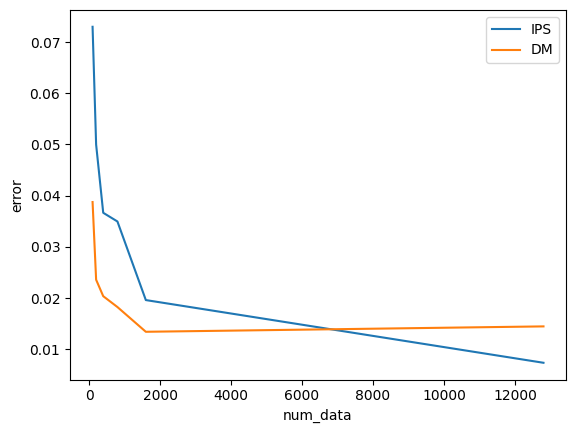

In [57]:
simulator.sim_nonlinear().plot(ylabel="error")